# Reverse Image Search

In [ ]:
import numpy as np
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
import urllib.request
from PIL import Image

In [ ]:
url = 'https://qph.fs.quoracdn.net/main-qimg-f22541ff53f37cb0fbf972c152b95120'

In [ ]:
import import_ipynb
from data603 import SparkLauncher
from data603 import HDFS
httpdfs = HDFS.get_httpdfs()
hdfs = HDFS.get_hdfs()

importing Jupyter notebook from /scratch/data603/yk98337/data603/SparkLauncher.ipynb
Creating Spark Configuration
importing Jupyter notebook from /scratch/data603/yk98337/data603/HDFS.ipynb


In [ ]:
import os
import pyarrow as pa
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import venv_pack

In [ ]:
import import_ipynb
from data603 import SparkLauncher

# get a configuration object
conf = SparkLauncher.get_spark_conf()

# add a file to the configuration that will get copied to all the nodes on the cluster
conf.set('spark.yarn.dist.files', 'keras_data/resnet50_weights_tf_dim_ordering_tf_kernels.h5')

# launch the cluster using the configuration
spark = SparkLauncher.get_spark_session(pack_venv = False, conf = conf)


Creating Spark Configuration
Setting Environment Variables
Creating Spark Session: yk98337_data603_spark_session


Defined a function to calculate the pixels per inch (ppi) of an image. Since most of the people have 15in laptops, I have assumed the length of the diagonal to be 15.4in i.e length of the diagonal of the laptop screen.

In [ ]:
def get_ppi(data):
    import math
    import io
    diagonal = 15.4
    img = Image.open(io.BytesIO(data))
    w,h = img.size
    ppi = math.sqrt((w^2)+(h^2))/diagonal
    return ppi

In [ ]:
import PIL
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql.functions import rank
from pyspark.sql import Window
from pyspark.sql.functions import desc
import pyspark.sql.functions as psf
import re

In [ ]:
def reverse_search(image):
    model = MobileNet(weights = 'imagenet',include_top = True,alpha = 1.0)
    img = load_img(urllib.request.urlopen(image), target_size = (224,224))
    image = img_to_array(img)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    yhat = model.predict(image)
    label = decode_predictions(yhat)
    cats = spark.read.parquet('/user/yk98337/land_mammals.parquet')
    names = []
    
    #taking the names of the labels from the original dataframe
    
    for i in label[0]:
        names.append(i[1])
    cats = cats.withColumn('LabelText',F.lower(F.col('Label')))
    n = cats.select('LabelText').distinct().collect()
    nam = []
    
    #taking the names of the labels from the predictions
    
    for i in range(len(n)):
        alp = ''
        for i in str(n[i]):
            if i.isalnum():
                alp += i
        alp = re.sub(r'^RowLabelText=*','',alp)
        nam.append(alp)
    nam
    cats1 = 0
    
    #filtering the images based on subset of interest
    
    for i in names:
        if i in nam:
            a = cats.where(cats['LabelText'] == i)
            if str(type(cats1)) == "<class 'pyspark.sql.dataframe.DataFrame'>":
                cats1 = cats1.union(a)
            else:
                cats1 = a
    #cats1 = cats1.select('LabelText','chip_data')
    schema = FloatType()
    cats1 = cats1.select('LabelText','chip_data')
    udf_evaluate_chip = udf(get_ppi, schema)
    cats1 = cats1.withColumn("ppi", udf_evaluate_chip("chip_data"))
    
    #ranking the images on ppi (pixel per inch)
    
    wA = Window.orderBy(desc("ppi"))
    rank_cats = cats1.withColumn("rank", psf.dense_rank().over(wA))
    rand_data = rank_cats.filter(rank_cats.rank.isin([2,3,4,5,6]))
    pd_rand_data = rand_data.toPandas()
    return pd_rand_data

In [ ]:
df = reverse_search(url)

In [ ]:
def print_image(data):
    img1 = Image.open(io.BytesIO(data))
    return(img1)

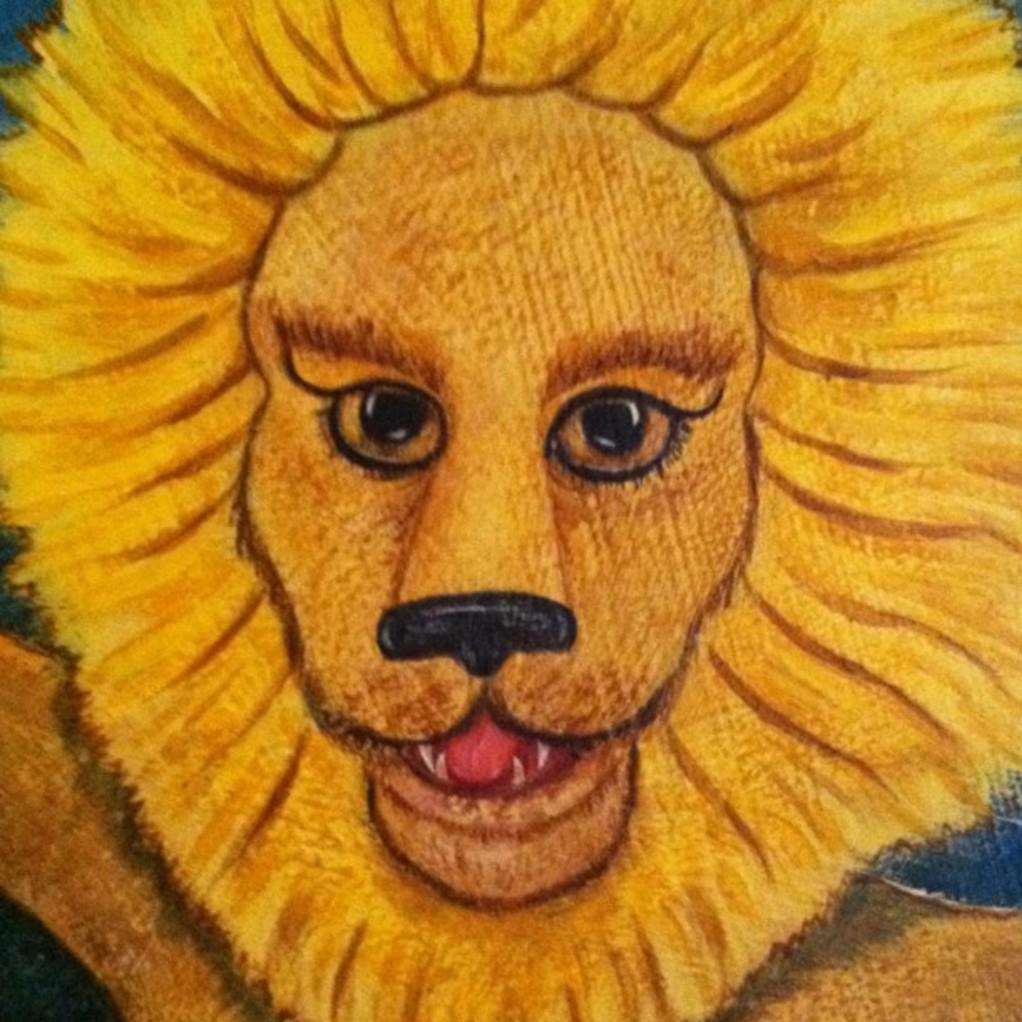

In [ ]:
import io
print_image(df['chip_data'][1])

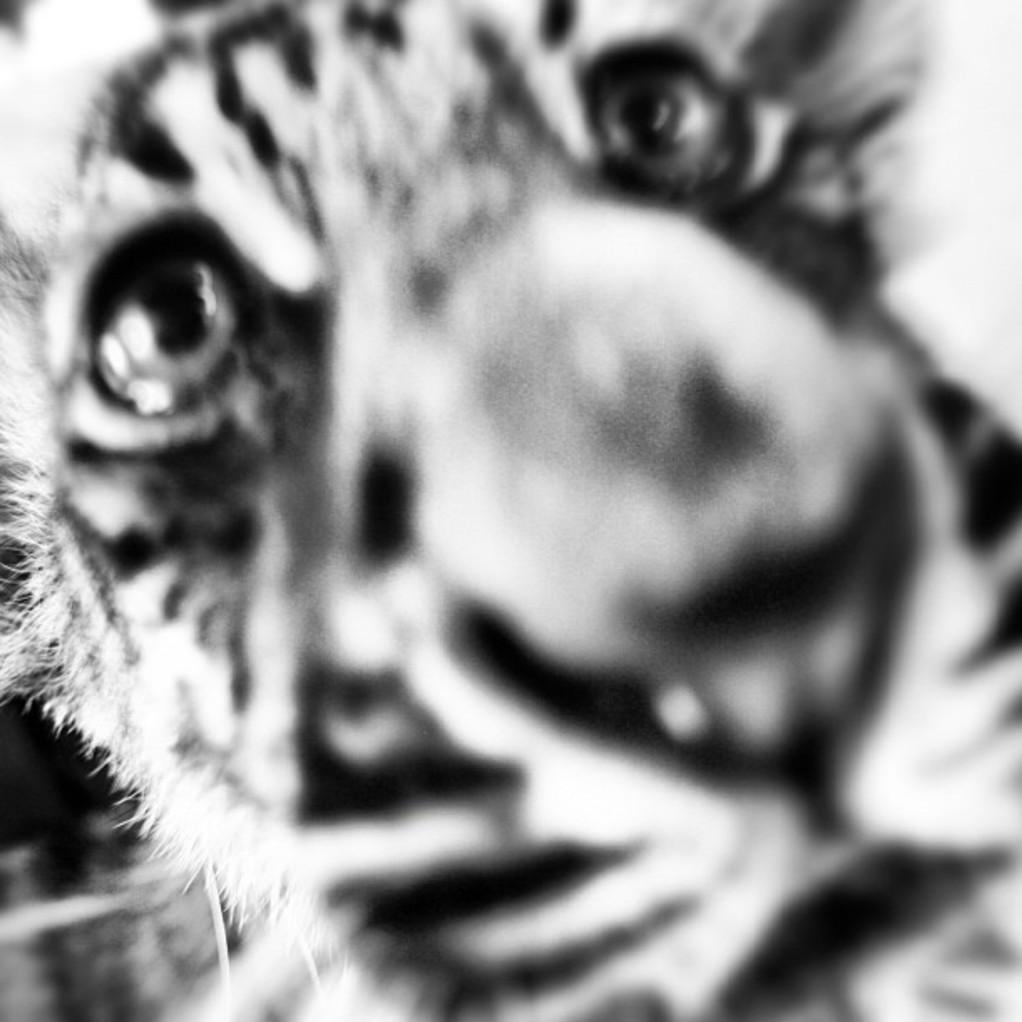

In [ ]:
print_image(df['chip_data'][2])

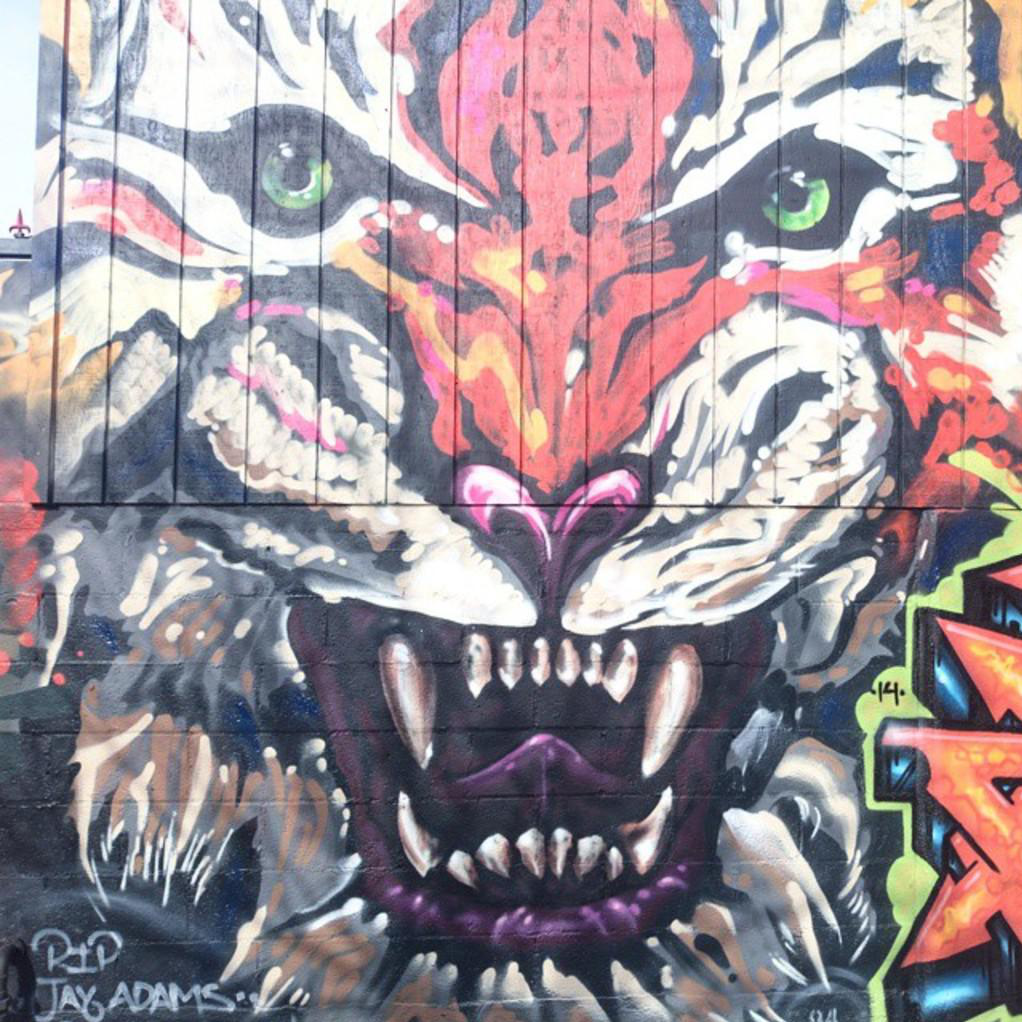

In [ ]:
print_image(df['chip_data'][3])

In [ ]:
spark.stop()

Most of the images are drawings. Since we gave an image of a real lion and a tiger, we would expect the algorithm to predict a real image. There is a scope for improvement on this process. Nevertheless, it did predict the images with correct labels.